<a href="https://colab.research.google.com/github/Richardesl10/Se-alesysistemasrichard/blob/main/DashboardRichard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Punto 7

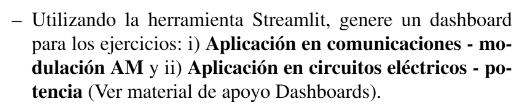

In [ ]:
#instalación de librerías
!pip install streamlit -q

In [ ]:
pip install streamlit yt-dlp soundfile numpy pandas scikit-learn matplotlib joblib

#Crear carpeta pages para trabajar Multiapp en Streamlit

In [ ]:
!mkdir pages

# Página principal

In [ ]:
%%writefile 0_👋_Bienvenida.py

import streamlit as st

st.set_page_config(
    page_title="Transformada de Fourier SyS",
    page_icon="✋",
)

st.write("# Análisis de la Transformada de Fourier 👋")

st.sidebar.success("Selecciona un tema para explorar.")

st.markdown(
    """
    ### Objetivo:
    * Implementar simulaciones y gráficos que representen señales y sus espectros en **dominio del tiempo** y **dominio de la frecuencia**.

    ### Aplicaciones:
    - Visualización del contenido espectral de señales.
    - Simulación de modulación por amplitud (AM) y análisis de su espectro.
    - Simulación de Calidad de energía (THD).
    - Detección del Género Musical de una canción, basándose en un modelo ya entrenado.
    - Implementación de gráficos interactivos utilizando **Streamlit** para representar conceptos clave.
"""
)

## **Páginas**

cada pagina se enviara al directorio /pages


 **Punto 4: Modulación AM**

In [ ]:
%%writefile 1_Modulación_AM_🔉.py
import streamlit as st
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import yt_dlp
import os

# --- Funciones Auxiliares ---

def descargar_y_cargar_audio(url, start_time=20, end_time=25, target_fs=22050):
    """
    Descarga el audio de una URL de YouTube, lo recorta a un intervalo específico,
    lo convierte a mono, lo remuestrea y lo carga como un array de NumPy.
    """
    temp_filename = "temp_audio"
    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192',
        }],
        'outtmpl': temp_filename,
        'quiet': True,
    }

    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])

        # Cargar el archivo WAV descargado
        fs, audio_data = wavfile.read(temp_filename + ".wav")

        # --- MODIFICACIÓN: Recortar el audio ---
        st.info(f"Analizando el audio entre el segundo {start_time} y {end_time}.")
        start_sample = int(start_time * fs)
        end_sample = int(end_time * fs)

        if end_sample > len(audio_data):
            st.warning(f"El audio es más corto que {end_time} segundos. Se usará el fragmento disponible.")
            end_sample = len(audio_data)

        if start_sample >= len(audio_data):
            st.error(f"El punto de inicio ({start_time}s) está más allá de la duración del audio. No se puede procesar.")
            os.remove(temp_filename + ".wav")
            return None, None

        audio_data = audio_data[start_sample:end_sample]
        # --- FIN DE LA MODIFICACIÓN ---

        # Convertir a mono si es estéreo
        if audio_data.ndim > 1:
            audio_data = np.mean(audio_data, axis=1)

        # Remuestrear a la frecuencia de muestreo objetivo (target_fs)
        if fs != target_fs:
            num_samples = int(len(audio_data) * float(target_fs) / fs)
            audio_data = signal.resample(audio_data, num_samples)
            fs = target_fs  # Actualizar la frecuencia de muestreo a la nueva

        # Normalizar el audio a un rango de -1 a 1
        if np.max(np.abs(audio_data)) > 0:
            audio_normalizado = audio_data / np.max(np.abs(audio_data))
        else:
            audio_normalizado = audio_data

        # Limpiar el archivo temporal
        os.remove(temp_filename + ".wav")

        return audio_normalizado, fs

    except Exception as e:
        st.error(f"Error al procesar el audio: {e}")
        return None, None

# --- Interfaz de Streamlit ---

st.set_page_config(layout="wide")
st.title("📟 Modulación y Demodulación de Amplitud (AM)")

st.markdown("""
Esta aplicación demuestra el proceso de modular una señal de audio (de YouTube) en Amplitud Modulada (AM)
y luego demodularla paso a paso utilizando un detector coherente.
""")

st.markdown("""
La **modulación por amplitud (AM)** es una técnica utilizada en comunicaciones donde la amplitud de una portadora
sinusoidal se varía en proporción a la amplitud de la señal mensaje. En esta página, exploraremos la modulación AM
utilizando una señal de audio de un enlace de YouTube como señal mensaje y las etapas de su demodulación.
""")

# --- Controles del Usuario ---
st.sidebar.header("Parámetros de Modulación")
url = st.sidebar.text_input("Ingresa la URL de un video de YouTube:", "https://www.youtube.com/watch?v=dQw4w9WgXcQ")
Am = st.sidebar.slider("Amplitud de la Portadora (Ac)", 0.1, 5.0, 1.0, 0.1)
fc = st.sidebar.slider("Frecuencia de la Portadora (fc) en Hz", 500, 5000, 5000, 100)
k_am = st.sidebar.slider("Índice de Modulación (ka)", 0.1, 1.5, 1.0, 0.1)

if st.sidebar.button("Procesar Audio y Modular"):
    if not url:
        st.warning("Por favor, ingresa una URL de YouTube.")
    else:
        with st.spinner("Descargando y procesando audio..."):
            audio_original, fs = descargar_y_cargar_audio(url, start_time=20, end_time=25)

        if audio_original is not None:
            # Crear vector de tiempo
            duracion = len(audio_original) / fs
            t = np.linspace(0, duracion, len(audio_original), endpoint=False)

            # --- 1. Señal Original (Mensaje) ---
            st.header("1. Señal de Audio Original (del segundo 20 al 25)")
            st.markdown("Esta es la señal de audio (mensaje) que será modulada.")

            fig_orig, ax_orig = plt.subplots(figsize=(12, 4))
            ax_orig.plot(t, audio_original, color='cornflowerblue')
            ax_orig.set_title("Señal de Audio Original (Mensaje)")
            ax_orig.set_xlabel("Tiempo (s)")
            ax_orig.set_ylabel("Amplitud Normalizada")
            ax_orig.grid(True)
            st.pyplot(fig_orig)

            st.audio(audio_original, sample_rate=fs)

            # --- 2. Proceso de Modulación AM ---
            st.header("2. Modulación en Amplitud (AM)")
            st.markdown(f"Se modula la señal usando la fórmula: $s(t) = A_c [1 + k_a m(t)] \\cos(2\\pi f_c t)$.")

            # --- NUEVA SECCIÓN: Explicación del Espectro ---
            with st.expander("Ver derivación del Espectro de Frecuencia AM"):
                st.markdown(r"""
                Para encontrar el espectro de frecuencia, $Y(f)$, de la señal modulada $y(t)$, aplicamos la Transformada de Fourier.
                Partimos de la ecuación en el tiempo:
                $$ y(t) = (1 + \frac{m(t)}{A_c})c(t) = A_c \cos(2\pi F_c t) + m(t) \cos(2\pi F_c t) $$
                Aplicando la transformada a cada término:
                1.  **Transformada de la portadora:** $\mathcal{F}\{A_c \cos(2\pi F_c t)\} = \frac{A_c}{2} [\delta(f - F_c) + \delta(f + F_c)]$
                2.  **Transformada del mensaje modulado (usando la propiedad de modulación):** $\mathcal{F}\{m(t) \cos(2\pi F_c t)\} = \frac{1}{2} [M(f - F_c) + M(f + F_c)]$

                El espectro completo es la suma de ambos:
                $$ Y(f) = \frac{A_c}{2} [\delta(f - F_c) + \delta(f + F_c)] + \frac{1}{2} [M(f - F_c) + M(f + F_c)] $$
                Este espectro consiste en los impulsos de la portadora y las bandas laterales (superior e inferior) que contienen la información del mensaje $m(t)$ trasladada en frecuencia.
                """)
            # --- FIN DE LA NUEVA SECCIÓN ---

            # Generar la señal portadora
            portadora = Am * np.cos(2 * np.pi * fc * t)

            # Generar la señal modulada en AM
            y_modulada_am = (1 + k_am * audio_original) * portadora

            fig_mod, ax_mod = plt.subplots(figsize=(12, 4))
            ax_mod.plot(t, y_modulada_am, color='red')
            ax_mod.set_title("Señal Modulada en AM")
            ax_mod.set_xlabel("Tiempo (s)")
            ax_mod.set_ylabel("Amplitud")
            ax_mod.grid(True)
            st.pyplot(fig_mod)

            st.audio(y_modulada_am, sample_rate=fs)

            # --- 3. Proceso de Demodulación ---
            st.header("3. Proceso de Demodulación Coherente (por Etapas)")
            st.info("Aquí se muestra el proceso paso a paso para recuperar la señal de audio original.")

            # Etapa 1: Multiplicación por la Portadora
            st.subheader("Paso 3.1: Multiplicación por la Señal Portadora")
            st.markdown("""
            La señal modulada en AM se multiplica por la misma señal portadora original.
            Esto desplaza el espectro de la señal de vuelta a sus frecuencias originales, pero también crea una componente de alta frecuencia no deseada alrededor de $2f_c$.
            """)
            s_demod_1 = y_modulada_am * portadora
            fig_demod_1, ax_demod_1 = plt.subplots(figsize=(12, 4))
            ax_demod_1.plot(t, s_demod_1, color='orange')
            ax_demod_1.set_title("Señal Después de la Multiplicación por la Portadora")
            ax_demod_1.set_xlabel("Tiempo (s)")
            ax_demod_1.set_ylabel("Amplitud")
            ax_demod_1.grid(True)
            st.pyplot(fig_demod_1)
            st.audio(s_demod_1, sample_rate=fs)
            st.warning("El sonido en esta etapa es agudo y ruidoso debido a la componente de alta frecuencia que aún no ha sido eliminada.")
            st.divider()

            # Etapa 2: Filtrado con Filtro Pasa-Bajas
            st.subheader("Paso 3.2: Filtrado con un Filtro Pasa-Bajas")
            fm = 4000  # Frecuencia de corte para el audio
            st.markdown(f"""
            Para eliminar la componente de alta frecuencia, se aplica un **filtro pasa-bajas**.
            Este filtro permite el paso de las frecuencias de la señal de audio (hasta **{fm} Hz**) y atenúa las frecuencias más altas.
            """)
            orden_filtro = 4
            wn_normalizada = 2 * fm / fs
            b, a = signal.butter(orden_filtro, wn_normalizada, btype='low')
            s_demod_2_filtrada = signal.lfilter(b, a, s_demod_1)
            fig_demod_2, ax_demod_2 = plt.subplots(figsize=(12, 4))
            ax_demod_2.plot(t, s_demod_2_filtrada, color='green')
            ax_demod_2.set_title("Señal Después del Filtrado Pasa-Bajas")
            ax_demod_2.set_xlabel("Tiempo (s)")
            ax_demod_2.set_ylabel("Amplitud")
            ax_demod_2.grid(True)
            st.pyplot(fig_demod_2)
            st.audio(s_demod_2_filtrada, sample_rate=fs)
            st.info("El audio ahora suena mucho más claro, ya que el ruido de alta frecuencia ha sido eliminado.")
            st.divider()

            # Etapa 3: Amplificación
            st.subheader("Paso 3.3: Amplificación y Recuperación Final")
            st.markdown(f"""
            Finalmente, para restaurar la amplitud original de la señal, la multiplicamos por un factor de ganancia.
            """)
            ganancia = 2 / (Am * Am) # Ganancia teórica para compensar
            s_demod_3_final = s_demod_2_filtrada * ganancia
            fig_demod_3, ax_demod_3 = plt.subplots(figsize=(12, 4))
            ax_demod_3.plot(t, s_demod_3_final, color='dodgerblue', label='Señal Recuperada')
            ax_demod_3.plot(t, audio_original, 'r--', label='Original (Referencia)', alpha=0.7)
            ax_demod_3.set_title("Señal de Audio Final Recuperada vs. Original")
            ax_demod_3.set_xlabel("Tiempo (s)")
            ax_demod_3.set_ylabel("Amplitud")
            ax_demod_3.legend()
            ax_demod_3.grid(True)
            st.pyplot(fig_demod_3)
            st.audio(s_demod_3_final, sample_rate=fs)
            st.success("¡Esta es la señal de audio final, demodulada y restaurada!")

**Punto 5: Quinto Punto: Aplicación en circuitos eléctricos-potencia (THD)**

In [ ]:
%%writefile 2_Factor_de_Potencia_THD_⚡.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import scipy.integrate as integrate

st.set_page_config(
    page_title="Factor de Potencia (THD)",
    page_icon="⚡",
    layout="wide",
)

st.markdown("""
    # Factor de Potencia y Distorsión Armónica Total (THD) ⚡

    ### ¿Qué es la Distorsión Armónica Total (THD) y el Factor de Potencia?

    En un circuito eléctrico, la forma de onda de la corriente o el voltaje puede no ser una sinusoide pura,
    especialmente cuando hay cargas no lineales (como rectificadores, variadores de velocidad, etc.).
    Esta desviación de la forma de onda ideal se debe a la presencia de **armónicos**, que son componentes
    sinusoidales a múltiplos enteros de la frecuencia fundamental.

    *   **Distorsión Armónica Total (THD):** Es una medida de cuánta distorsión armónica hay en una señal. Se define como la relación entre la suma cuadrática (RMS) de todas las componentes armónicas y la componente fundamental. Para la corriente ($I$) y el voltaje ($V$):

    $$THD_I= (\sqrt{I_2 ^2 + I_3 ^2 + I_4 ^2 +\dots})/({I_1}) * 100\%$$

    $$THD_V=(\sqrt{V_2 ^2 + V_3 ^2 + V_4 ^2 + \dots})/({V_1}) * 100\%$$

    Donde $I_n$ y $V_n$ son los valores RMS de la n-ésima componente armónica de la corriente y el voltaje, respectivamente, y $I_1$ y $V_1$ son los valores RMS de la fundamental.

    *   **Factor de Potencia (FP):** En circuitos de corriente alterna, el factor de potencia es la relación entre
        la potencia activa (real) utilizada por la carga y la potencia aparente total suministrada. Se puede
        descomponer en dos partes:

        $$ FP = FP_{desplazamiento} * FP_{distorsión} $$

        -   **Factor de Potencia por Desplazamiento ($\cos(\phi)$):** Relacionado con el ángulo de fase ($\phi$) entre
            la componente fundamental del voltaje y la fundamental de la corriente.
        -   **Factor de Potencia por Distorsión:** Relacionado con la presencia de armónicos.

        Cuando la forma de onda no es sinusoidal pura, el factor de potencia total también se ve afectado por la
        distorsión.

    ### Cálculo del THD desde la FFT

    La Transformada Rápida de Fourier (FFT) nos permite descomponer una señal en sus componentes de frecuencia,
    revelando las magnitudes de la fundamental y de los armónicos.

    Dada una señal $x(t)$ muestreada en el tiempo, su FFT $X[k]$ nos da la magnitud y fase de las componentes
    en diferentes frecuencias. La magnitud de la componente fundamental ($X[k_1]$) y de los armónicos ($X[k_n]$)
    se encuentran en los índices $k_1$ y $k_n$ correspondientes a las frecuencias $f_1$ y $n \cdot f_1$.

    El valor RMS de una componente sinusoidal con magnitud $A$ es $A/\sqrt{2}$. Para una señal real $x(t)$ de longitud $N$, la magnitud de la FFT $X[k]$ está relacionada con la amplitud de la componente de frecuencia $f_k$.

    Para una señal real $x$ de $N$ muestras, con fundamental en la frecuencia $f_1$:
    1.  Calcular la FFT: `X = fft(x)`
    2.  Calcular las frecuencias correspondientes: `freqs = fftfreq(N, 1/fs)`
    3.  Identificar el índice $k_1$ correspondiente a la frecuencia fundamental $f_1$.
    4.  Identificar los índices $k_n$ correspondientes a los armónicos $n \cdot f_1$.
    5.  La magnitud de la fundamental es $|X[k_1]|$. El valor RMS de la fundamental es $I_1 = |X[k_1]| / (\sqrt{2} \cdot N/2) = |X[k_1]| \cdot \sqrt{2} / N$ para señales reales.
    6.  Las magnitudes de los armónicos son $|X[k_n]|$. Los valores RMS de los armónicos son $I_n = |X[k_n]| \cdot \sqrt{2} / N$.
    7.  Sustituir en la fórmula del THD.

    Una forma práctica usando `numpy` para la magnitud del espectro unilateral ($N/2+1$ puntos):
    Sea $P1$ el espectro de magnitud unilateral normalizado (como en el ejemplo de AM):
    $P1[k]$ es la amplitud de la componente en frecuencia $f_k$.

    El valor RMS de la fundamental es $I_1 = P1[k_1]/\sqrt{2}$.

    El valor RMS de los armónicos es $I_n = P1[k_n]/\sqrt{2}$.

    Entonces:

    $$ THD_I = (\sqrt{\sum_{n=2}^{N_{harm}} (P1[k_n]/\sqrt{2})^2})/(P1[k_1]/\sqrt{2}) = (\sqrt{\sum_{n=2}^{N_{harm}} P1[k_n]^2})/(P1[k_1]) $$

    Donde $N_{harm}$ es el número de armónicos considerados.

    ### Cálculo de la Distorsión del Factor de Potencia con base al THD

    El factor de potencia total en presencia de armónicos se puede calcular como:

    $$ FP = P/S = (Potencia Activa)/(Potencia Aparente) $$

    La potencia aparente ($S$) para formas de onda no sinusoidales se calcula usando los valores RMS totales (fundamental + armónicos) del voltaje ($V_{RMS}$) y la corriente ($I_{RMS}$):

    $$ S = V_{RMS} \cdot I_{RMS} $$

    El valor RMS total de una señal con armónicos es:
    $$ X_{RMS} = \sqrt{X_1^2 + X_2^2 + X_3^2 + \dots} = X_1 \sqrt{1 + \text{THD}_X^2} $$
    Donde $X$ puede ser voltaje o corriente.

    La potencia activa ($P$) es la potencia disipada en la resistencia y se calcula como la suma de las potencias activas de cada armónico (solo contribuye la fundamental y los armónicos presentes tanto en voltaje como en corriente y en fase):

    $$ P = V_1 I_1 \cos(\phi_1) + V_2 I_2 \cos(\phi_2) + \dots $$
    En muchos casos (voltaje de fuente casi sinusoidal), la potencia activa es dominada por la fundamental: $P = V_1 I_1 \cos(\phi_1)$.

    El factor de potencia por distorsión se relaciona con el THD de la corriente por la siguiente fórmula:

    $$ FP_{distorsión} = (I_1)/(I_{RMS}) = (I_1)/(I_1 \sqrt{1 + THD_I^2}) = (1)/(\sqrt{1 + THD_I^2}) $$

    Así, el factor de potencia total puede aproximarse (si el voltaje de la fuente es ideal sinusoidal y la distorsión del voltaje es despreciable) como:

    $$ FP = \cos(\phi_1) * 1/(\sqrt{1 + THD_I^2}) $$

    Donde $\cos(\phi_1)$ es el factor de potencia por desplazamiento, calculado con el ángulo de fase entre la fundamental de voltaje y corriente. En circuitos puramente resistivos ($\phi_1=0$), $\cos(\phi_1)=1$, y el FP se reduce a $1/(\sqrt{1 + THD_I^2})$.

    ### Ejemplo Ilustrativo: Rectificador de Onda Completa

    Simularemos la corriente a través de una carga conectada a un rectificador de onda completa, alimentado por una fuente de voltaje sinusoidal. Analizaremos dos casos de carga: puramente resistiva (R) y RC en serie.

    Consideramos una fuente de voltaje sinusoidal: $v(t) = V_p \sin(2\pi f t)$.
    La salida del rectificador de onda completa (asumiendo diodos ideales) es $|v(t)| = V_p |\sin(2\pi f t)|$.

    La corriente a través de la carga $i(t)$ dependerá de la impedancia de la carga a la tensión rectificada.

    #### Caso i) Carga puramente Resistiva (R)

    Para una carga puramente resistiva $R$, la corriente instantánea es simplemente $i(t) = |v(t)| / R = (V_p/R) |\sin(2\pi f t)|$. La forma de onda de la corriente es idéntica a la de la tensión rectificada, escalada por $1/R$.

    #### Caso ii) Carga RC en Serie

    Para una carga RC en serie, la corriente es más compleja de calcular analíticamente, ya que depende de la dinámica de carga y descarga del condensador. La corriente fluirá principalmente cuando el voltaje rectificado sea mayor que el voltaje en el condensador. El condensador tenderá a mantener un voltaje cercano al pico, y la corriente fluirá en pulsos cortos cuando la tensión de entrada supere la tensión del condensador. Esto resulta en una forma de onda de corriente muy distorsionada.

    ### Simulación y Análisis

    Utilizaremos las siguientes condiciones para la simulación:
    *   Frecuencia de la fuente: $f = 60$ Hz
    *   Voltaje pico de la fuente: $V_p = 10$ V
    *   Frecuencia de muestreo: $fs = 200 \cdot f$ (suficiente para capturar armónicos)
    *   Duración de la simulación: Varios ciclos de la fundamental (ej: 4 ciclos)

    Sliders de control para R y C:
""")

# --- Parámetros de simulación ---
f = 60  # Hz
Vp = 10 # V
fs_sim = 200 * f # Hz
duration_sim = 4 / f # segundos (4 ciclos)
N_sim = int(fs_sim * duration_sim)
t_sim = np.linspace(0, duration_sim, N_sim, endpoint=False)

st.subheader("Parámetros de Carga")
resistance = st.slider("Valor de la Resistencia R (Ohms)", 1.0, 100.0, 10.0, step=1.0)
capacitance_nf = st.slider("Valor del Condensador C (nF)", 0.0, 1000.0, 0.0, step=10.0)
capacitance = capacitance_nf * 1e-9 # Convertir nF a Faradios

# --- Cálculo de señales ---
v_source = Vp * np.sin(2 * np.pi * f * t_sim)
v_rectified = np.abs(v_source)

i_r_load = v_rectified / resistance

# Simulación de carga RC (simplificada por simulación numérica simple)
# Esto es una aproximación. Una simulación de circuito real es compleja.
# Aquí, simulamos la respuesta de un circuito RC a la tensión rectificada.
# Ecuación: v_rectified(t) = R*i(t) + v_c(t)
# dv_c/dt = i(t)/C
# i(t) = (v_rectified(t) - v_c(t))/R
# dv_c/dt = (v_rectified(t) - v_c(t))/(R*C)
# Usamos integración numérica simple (Euler)
dt = 1.0 / fs_sim
i_rc_load = np.zeros(N_sim)
v_c = 0.0

if capacitance > 1e-12: # Solo si hay capacitor
    for k in range(N_sim - 1):
        i_rc_load[k] = (v_rectified[k] - v_c) / resistance
        dv_c = i_rc_load[k] * dt / capacitance
        v_c += dv_c
        # El capacitor no puede tener un voltaje mayor al pico de la fuente rectificada
        if v_c > v_rectified[k+1]:
             v_c = v_rectified[k+1]
else: # Comportamiento resistivo si C es muy pequeño
     i_rc_load = i_r_load


# --- Cálculo de FFT y THD ---

def calculate_thd(signal, fs, fundamental_freq, num_harmonics=10):
    """ Calcula el THD de una señal """
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1/fs)

    # Encontrar la fundamental
    # Buscar el pico cerca de la fundamental_freq (o 2*fundamental_freq para rectificada)
    # La frecuencia fundamental de la señal rectificada de 60Hz es 120Hz
    target_fund_freq = 2 * fundamental_freq
    fundamental_idx = np.argmin(np.abs(xf - target_fund_freq))
    fundamental_magnitude = 2.0/N * np.abs(yf[fundamental_idx])

    if fundamental_magnitude < 1e-9: # Evitar división por cero
        return np.nan, xf[0:N//2], 2.0/N * np.abs(yf[0:N//2]) # Retornar espectro unilateral

    harmonic_magnitudes_sq = 0
    max_harm_idx = 0
    freqs_unilateral = xf[0:N//2]
    magnitudes_unilateral = 2.0/N * np.abs(yf[0:N//2])

    for n in range(2, num_harmonics + 2): # Armónicos de la fundamental rectificada (2*f, 3*f, 4*f, etc.)
        harmonic_freq = n * target_fund_freq
        harmonic_idx = np.argmin(np.abs(xf - harmonic_freq))
        if harmonic_idx < N // 2: # Asegurarse de estar en el rango unilateral
             harmonic_magnitude = 2.0/N * np.abs(yf[harmonic_idx])
             harmonic_magnitudes_sq += harmonic_magnitude**2
             max_harm_idx = max(max_harm_idx, harmonic_idx)


    thd = np.sqrt(harmonic_magnitudes_sq) / fundamental_magnitude * 100

    # Recortar espectro para visualización hasta el último armónico considerado + un poco
    view_limit_hz = (num_harmonics + 2) * target_fund_freq * 1.2
    view_idx_limit = np.argmin(np.abs(freqs_unilateral - view_limit_hz)) + 10
    view_idx_limit = min(view_idx_limit, N // 2) # No exceder el límite de N//2

    return thd, freqs_unilateral[:view_idx_limit], magnitudes_unilateral[:view_idx_limit]


thd_r, freqs_r, mags_r = calculate_thd(i_r_load, fs_sim, f)
thd_rc, freqs_rc, mags_rc = calculate_thd(i_rc_load, fs_sim, f)

# Cálculo del Factor de Potencia por Distorsión
fp_distortion_r = 1 / np.sqrt(1 + (thd_r/100)**2) if not np.isnan(thd_r) else np.nan
fp_distortion_rc = 1 / np.sqrt(1 + (thd_rc/100)**2) if not np.isnan(thd_rc) else np.nan


# --- Mostrar resultados ---
st.subheader("Resultados de la Simulación")

col1, col2 = st.columns(2)

with col1:
    st.markdown("### Carga Resistiva (R)")
    st.write(f"Resistencia: {resistance} Ohms")
    st.write(f"THD de la Corriente: {thd_r:.2f} %" if not np.isnan(thd_r) else "THD no calculado")
    st.write(f"Factor de Potencia por Distorsión: {fp_distortion_r:.4f}" if not np.isnan(fp_distortion_r) else "FP Distorsión no calculado")


with col2:
    st.markdown("### Carga RC en Serie")
    st.write(f"Resistencia: {resistance} Ohms")
    st.write(f"Capacitancia: {capacitance_nf} nF")
    st.write(f"THD de la Corriente: {thd_rc:.2f} %" if not np.isnan(thd_rc) else "THD no calculado")
    st.write(f"Factor de Potencia por Distorsión: {fp_distortion_rc:.4f}" if not np.isnan(fp_distortion_rc) else "FP Distorsión no calculado")

# --- Graficar formas de onda ---
st.subheader("Formas de Onda de Corriente")
fig_waveforms, ax_waveforms = plt.subplots(figsize=(12, 6))
ax_waveforms.plot(t_sim, i_r_load, label="Carga Resistiva (R)", alpha=0.7)
if capacitance_nf > 0:
    ax_waveforms.plot(t_sim, i_rc_load, label=f"Carga RC (R={resistance}Ω, C={capacitance_nf}nF)", alpha=0.7)
ax_waveforms.set_xlabel("Tiempo [s]")
ax_waveforms.set_ylabel("Corriente [A]")
ax_waveforms.set_title("Corriente a través de la Carga")
ax_waveforms.legend()
ax_waveforms.grid(True)
st.pyplot(fig_waveforms)

# --- Graficar espectros de frecuencia ---
st.subheader("Espectros de Frecuencia de Corriente")
fig_spectrums, ax_spectrums = plt.subplots(figsize=(12, 6))
ax_spectrums.plot(freqs_r, mags_r, label="Espectro Corriente Carga R", alpha=0.7)
if capacitance_nf > 0:
    ax_spectrums.plot(freqs_rc, mags_rc, label=f"Espectro Corriente Carga RC (R={resistance}Ω, C={capacitance_nf}nF)", alpha=0.7)
ax_spectrums.set_xlabel("Frecuencia [Hz]")
ax_spectrums.set_ylabel("Magnitud")
ax_spectrums.set_title("Espectro de Frecuencia de la Corriente")
ax_spectrums.set_xlim(0, 15 * f) # Limitar eje X para mejor visualización de armónicos
ax_spectrums.legend()
ax_spectrums.grid(True)
st.pyplot(fig_spectrums)

# --- Discusión de Resultados ---
st.subheader("Discusión de Resultados")
st.markdown("""
   **Carga Puramente Resistiva (R):**
La corriente tiene la misma forma que la tensión rectificada (semiciclos negativos invertidos). Su espectro muestra una fundamental a 120 Hz y armónicos pares (240 Hz, 360 Hz, ...). Aunque el FP por desplazamiento es 1 (corriente en fase con tensión), el FP total disminuye debido al alto contenido armónico (THD elevado).

**Carga RC en Serie:**
El condensador cambia la forma de la corriente, que ahora fluye en picos cortos y altos cuando la tensión supera al voltaje del capacitor. Esto genera una forma de onda más distorsionada, con armónicos de mayor amplitud y frecuencia. El THD aumenta considerablemente, reduciendo el FP total, aunque el FP por desplazamiento puede seguir cercano a 1.

**Observaciones:**
- Prueba distintos valores de R y C con los sliders.
- A mayor C, los pulsos de corriente se hacen más breves y más intensos, aumentando el THD.
- Un THD alto reduce el FP y puede causar sobrecalentamientos o problemas en redes eléctricas.
- Esta es una simulación simplificada; un análisis completo requiere modelar los diodos y la interacción total entre fuente, rectificador y carga.
""")

 **3. Detector de Género**

In [ ]:
%%writefile 3_Detector_de_Genero_Musical_🎶.py
import streamlit as st
import yt_dlp
import os
import soundfile as sf
import numpy as np
import librosa
import joblib
import io

#--- Funciones Auxiliares ---#

def download_youtube_audio(url, output_path='downloaded_audio'):
    """Descarga el audio de un video de YouTube en formato .wav."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192',
        }],
        'outtmpl': os.path.join(output_path, '%(title)s.%(ext)s'),
        'quiet': True,
        'noplaylist': True,
    }

    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info_dict = ydl.extract_info(url, download=True)
            base_filename = ydl.prepare_filename(info_dict)
            output_filename = os.path.splitext(base_filename)[0] + '.wav'
            return output_filename
    except Exception as e:
        st.error(f"Error al descargar de YouTube: {e}")
        return None

def extract_features(audio_path, fixed_length):
    """
    Extrae características MFCC de un archivo de audio, las aplana y las ajusta a una longitud fija.
    """
    try:
        y, sr = librosa.load(audio_path, sr=None, duration=60)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        features = mfccs.flatten()

        if len(features) > fixed_length:
            features = features[:fixed_length]
        else:
            features = np.pad(features, (0, fixed_length - len(features)), 'constant')

        return features
    except Exception as e:
        st.error(f"Error al procesar el archivo de audio: {e}")
        return None

#--- Lógica de Carga de Modelo ---#

@st.cache_resource
def load_model_from_path(path):
    try:
        with open(path, 'rb') as f:
            return joblib.load(f)
    except FileNotFoundError:
        return None

# <<--- INICIO: BLOQUE DE CÓDIGO ACTUALIZADO Y MÁS ROBUSTO --- >>
# Se ejecuta solo una vez para cargar el modelo por defecto.
# Ahora incluye manejo específico para el EOFError.
if 'model_dict' not in st.session_state:
    default_model_path = 'pop_vs_reggaeton.pkl'
    try:
        with st.spinner(f"Cargando modelo por defecto: {default_model_path}..."):
            model_dict = load_model_from_path(default_model_path)

        if model_dict:
            st.session_state['model_dict'] = model_dict
            st.session_state['model_name'] = default_model_path
        else:
            # Maneja el caso en que el archivo no fue encontrado por la función auxiliar
            st.session_state['model_dict'] = None
            st.session_state['model_name'] = None
    except EOFError:
        # Captura el error específico que estás viendo y muestra un mensaje claro.
        st.session_state['model_dict'] = None
        st.session_state['model_name'] = None
        # En la interfaz principal, se mostrará una advertencia gracias a esta lógica.
    except Exception as e:
        # Captura cualquier otro error inesperado durante la carga
        st.error(f"Ocurrió un error inesperado al cargar '{default_model_path}': {e}")
        st.session_state['model_dict'] = None
        st.session_state['model_name'] = None
# <<--- FIN: BLOQUE DE CÓDIGO ACTUALIZADO --- >>

#--- Interfaz de Streamlit ---#
st.title("Dashboard de Análisis Musical 🎶")

menu = ["Inicio", "Cargar Modelo", "Detector de Género"]
choice = st.sidebar.selectbox("Menú", menu)

if choice == "Inicio":
    st.header("Bienvenido al Dashboard de Análisis Musical")
    st.write("""
        Esta aplicación te permite predecir el género de una canción usando Machine Learning.
    """)
    if st.session_state.get('model_name') is None:
         st.error("No se pudo cargar el modelo por defecto 'pop_vs_reggaeton.pkl'. Por favor, verifica que el archivo exista, no esté corrupto y súbelo de nuevo si es necesario.")
    st.info(f"**Modelo actualmente cargado:** `{st.session_state.get('model_name', 'Ninguno')}`")
    st.write("""
        **Pasos para usar:**
        1.  **Modelo por Defecto:** La aplicación intenta cargar `pop_vs_reggaeton.pkl`. Si falla, puedes subir uno.
        2.  **Cargar Otro Modelo:** Ve al menú "Cargar Modelo" y sube tu propio archivo `.pkl`.
        3.  **Detector de Género:** Ingresa un enlace de YouTube para obtener la predicción del modelo activo.
    """)

elif choice == "Cargar Modelo":
    st.header("Carga de Modelo de Clasificación")
    st.write("Sube un modelo de Machine Learning en formato `.pkl` para reemplazar al modelo por defecto.")

    if st.session_state.get('model_name'):
        st.info(f"Modelo activo actual: **{st.session_state['model_name']}**")

    uploaded_file = st.file_uploader("Elige un archivo .pkl", type=["pkl"])

    if uploaded_file is not None:
        try:
            bytes_data = uploaded_file.getvalue()
            model_dict = joblib.load(io.BytesIO(bytes_data))

            if isinstance(model_dict, dict) and 'modelo' in model_dict:
                st.session_state['model_dict'] = model_dict
                st.session_state['model_name'] = uploaded_file.name
                st.success(f"¡Modelo '{uploaded_file.name}' cargado exitosamente!")
                st.info("Este modelo está ahora activo. Ve a 'Detector de Géenero' para usarlo.")
            else:
                st.error("El archivo .pkl no tiene el formato esperado. Debe ser un diccionario con una clave 'modelo'.")

        except Exception as e:
            st.error(f"Ocurrió un error al cargar el modelo: {e}")


elif choice == "Detector de Género":
    st.header("Detector de Género de Canciones")

    if 'model_dict' not in st.session_state or st.session_state.get('model_dict') is None:
        st.warning("No hay ningún modelo cargado. Asegúrate de que el archivo `pop_vs_reggaeton.pkl` exista y no esté corrupto, o sube un modelo manualmente desde el menú 'Cargar Modelo'.")
        st.stop()

    model_dict = st.session_state['model_dict']
    classifier = model_dict['modelo']
    n_features_expected = classifier.n_features_in_

    st.info(f"Usando el modelo: **{st.session_state['model_name']}**")

    youtube_link = st.text_input("Ingresa el enlace de YouTube para predecir su género")

    if youtube_link:
        if st.button("Predecir Género"):
            try:
                with st.spinner("Descargando y procesando audio..."):
                    audio_path = download_youtube_audio(youtube_link)

                    if audio_path:
                        features = extract_features(audio_path, fixed_length=n_features_expected)
                        os.remove(audio_path)

                        if features is not None:
                            features_reshaped = features.reshape(1, -1)
                            prediction = classifier.predict(features_reshaped)
                            probabilities = classifier.predict_proba(features_reshaped)

                            st.write(f"### El género predicho es: **{prediction[0]}**")
                            st.write("---")
                            st.write("#### Probabilidades por clase:")

                            for i, genre_label in enumerate(classifier.classes_):
                                st.write(f"- **{genre_label}:** {probabilities[0][i]*100:.2f}%")

            except Exception as e:
                st.error(f"Ocurrió un error inesperado durante el proceso de predicción: {e}")

In [ ]:
!mv 3_Detector_de_Genero_Musical_🎶.py pages/

## **Inicio del Dashboard con túnel local**

1. **Editar nombre del archivo**: Cambia el nombre del archivo según lo indicado en el comentario de la línea 6 del código.

2. **Usar el enlace generado**: Al ejecutar la celda, LocalTunnel creará un enlace temporal. Ábrelo o cópialo en tu navegador para acceder al Dashboard. Nota: el enlace puede cambiar cada vez que ejecutes la celda.

**Importante:**  
Para detener el Dashboard, ejecuta la última celda de código y sigue las instrucciones mostradas.

In [ ]:
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
!mv cloudflared-linux-amd64 /usr/local/bin/cloudflared

#Ejecutar Streamlit
!streamlit run 0_👋_Bienvenida.py &>/content/logs.txt & #Cambiar 0_👋_Hello.py por el nombre de tu archivo principal

#Exponer el puerto 8501 con Cloudflare Tunnel
!cloudflared tunnel --url http://localhost:8501 > /content/cloudflared.log 2>&1 &

#Leer la URL pública generada por Cloudflare
import time
time.sleep(5)  # Esperar que se genere la URL

import re
found_context = False  # Indicador para saber si estamos en la sección correcta

with open('/content/cloudflared.log') as f:
    for line in f:
        #Detecta el inicio del contexto que nos interesa
        if "Your quick Tunnel has been created" in line:
            found_context = True

        #Busca una URL si ya se encontró el contexto relevante
        if found_context:
            match = re.search(r'https?://\S+', line)
            if match:
                url = match.group(0)  #Extrae la URL encontrada
                print(f'Tu aplicación está disponible en: {url}')
                break  #Termina el bucle después de encontrar la URL

##Final del Proceso de ejecución del Dashboard

In [ ]:
import os

res = input("Digite (1) para finalizar la ejecución del Dashboard: ")

if res.upper() == "1":
    os.system("pkill streamlit")  # Termina el proceso de Streamlit
    print("El proceso de Streamlit ha sido finalizado.")